In [1]:
import enum
import typing
import itertools
import dataclasses
from pathlib import Path

import attrs
import numpy as np
from IPython import display

from arc25.dsl import types, primitives
from arc25.dsl import api as dsl
from arc25 import tools, dataset, sandbox

In [2]:
proj_root = Path("..").resolve()
data_path = proj_root / "data"
db_root = data_path / "solutions"
challenges_root = data_path / "arc-prize-2025.zip"

In [3]:
print(", ".join(types.__all__))

AnyImage, Axis4, Axis8, Canvas, Color, ColorArray, Coord, Dir4, Dir8, Image, Mask, MaskedImage, Paintable, Pattern, Rect, ShapeSpec, Transform, Vector


In [4]:
print(", ".join(primitives.__all__))

advance_pattern, apply_mask, cell_count, center_of_mass, connected_component, correlate_masks, count_colors, dilate, erode, extract_image, fill, find_bbox, find_cells, find_holes, find_objects, identify_background, make_canvas, mask_all, mask_col, mask_color, mask_from_string, mask_none, mask_row, mask_unpainted, masks_touch, most_common_colors, new_mask_like, paste, path_ray, path_segment, path_span, path_to_mask, pattern_cycle, pattern_dotted, pattern_solid, rect_to_mask, reduce_rect, round2grid, stroke, transform, vec2dir8


In [5]:
print(", ".join(dsl.__all__))

AnyImage, Axis4, Axis8, Canvas, Color, ColorArray, Coord, Dir4, Dir8, Image, Mask, MaskedImage, Paintable, Pattern, Rect, ShapeSpec, Transform, Vector, advance_pattern, apply_mask, cell_count, center_of_mass, connected_component, correlate_masks, count_colors, dilate, erode, extract_image, fill, find_bbox, find_cells, find_holes, find_objects, identify_background, make_canvas, mask_all, mask_col, mask_color, mask_from_string, mask_none, mask_row, mask_unpainted, masks_touch, most_common_colors, new_mask_like, paste, path_ray, path_segment, path_span, path_to_mask, pattern_cycle, pattern_dotted, pattern_solid, rect_to_mask, reduce_rect, round2grid, stroke, transform, vec2dir8, ROW, DIAG_ANTI, COL, DIAG_MAIN, ROW, COL, RIGHT, UP_RIGHT, UP, UP_LEFT, LEFT, DOWN_LEFT, DOWN, DOWN_RIGHT, RIGHT, UP, LEFT, DOWN, BLACK, BLUE, RED, GREEN, YELLOW, GRAY, MAGENTA, ORANGE, CYAN, BROWN, IDENTITY, FLIP_LR, FLIP_UD, ROTATE_180, FLIP_DIAG_MAIN, ROTATE_LEFT, ROTATE_RIGHT, FLIP_DIAG_ANTI


In [6]:
datasets = {}
for k in ["training", "evaluation", "test"]:
    datasets[k] = await dataset.Dataset.load(
        id=k,
        root=challenges_root,
        challenges=f"arc-agi_{k}_challenges.json",
        solutions=f"arc-agi_{k}_solutions.json" if k != "test" else None,
    )
ds = datasets["combined"] = dataset.Dataset(
    id="combined",
    challenges = dict(itertools.chain(*[ds.challenges.items() for ds in datasets.values()])),
)

In [7]:
solutions = await dataset.SolutionDB.load(db_root)
sol_with_code = sorted(k for k,v in solutions.solutions.items() if v.rule)
print(len(solutions.solutions), len(sol_with_code))
print(sol_with_code)

20 12
['00576224', '36fdfd69', '46442a0e', '54d82841', '642d658d', '6e19193c', '6f8cd79b', '9841fdad', '9f5f939b', 'a740d043', 'ce039d91', 'fd02da9e']


In [8]:
ckey = sol_with_code[8]
ckey = "fd02da9e"

sol = solutions.solutions[ckey]
print(f"Challenbge {ckey}:")
print("Explanation:")
display.display(display.Markdown(sol.explanation))
print("Rule:")
display.display(display.Code(sol.rule, language="python"))


Challenbge fd02da9e:
Explanation:


Rule:


def solution(input: Canvas, examples: list[IOPair]) -> Canvas:
    output = make_canvas(*input.shape)
    output = fill(output, ORANGE)
    keys = ~mask_color(input, ORANGE)
    for idx,io in enumerate(examples):
        if io.output is None:
            continue
        key = ~mask_color(io.input, ORANGE)
        value = ~mask_color(io.output, ORANGE)
        if (keys & key == key).all():
            c, = most_common_colors(apply_mask(input, key))
            output = fill(output, c, clip=value)
    return output

Overall: out.full_match=False out.example_match=0.0 out.cell_match=0.0
Traceback (most recent call last):
  File "/Users/yves/git-private/arc-2025/src/arc25/sandbox.py", line 183, in _evaluate_solution
    actual = solver(io.input, examples)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "<rule-code>", line 10, in solution
    if (keys & key == key).all():
       ^^^^^^^^^^^^^^^^^^^^^^^
AttributeError: 'Mask' object has no attribute 'all'
Train 0: v.full_match=False v.cell_match=0
Traceback (most recent call last):
  File "/Users/yves/git-private/arc-2025/src/arc25/sandbox.py", line 183, in _evaluate_solution
    actual = solver(io.input, examples)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "<rule-code>", line 10, in solution
    if (keys & key == key).all():
       ^^^^^^^^^^^^^^^^^^^^^^^
AttributeError: 'Mask' object has no attribute 'all'
Train 1: v.full_match=False v.cell_match=0
Traceback (most recent call last):
  File "/Users/yves/git-private/arc-2025/src/arc25/sandbox.py", 

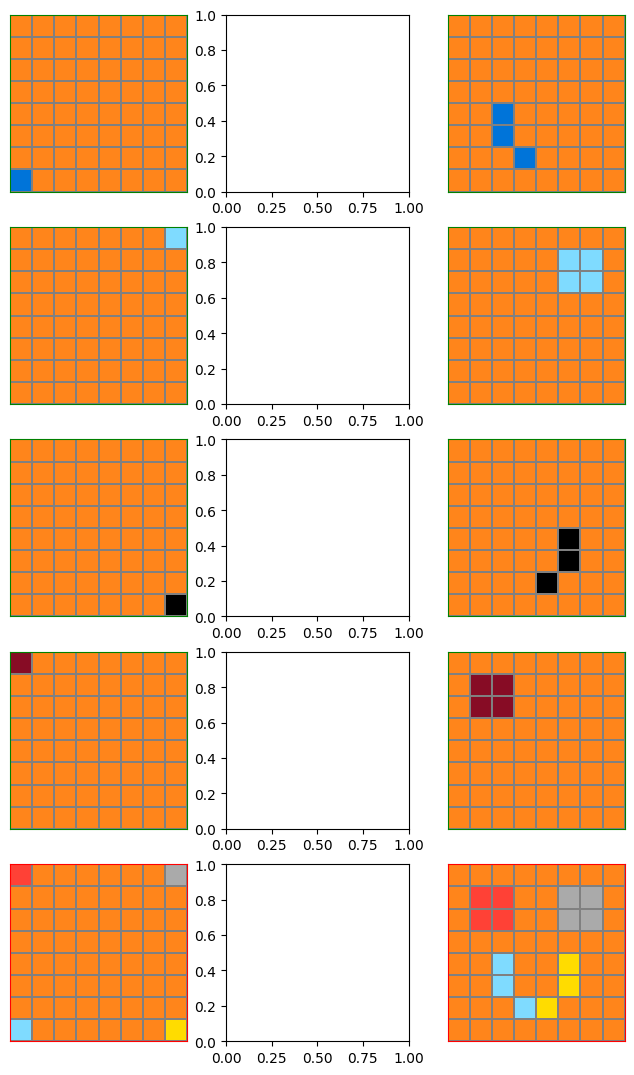

In [9]:
out = await sandbox.evaluate_solution(
    challenge=(chal := ds.challenges[ckey]),
    solution=solutions.solutions[ckey],
)
def ifp(s):
    if s:
        print(s)
print(f"Overall: {out.full_match=} {out.example_match=} {out.cell_match=}")
ifp(out.exec_info.stdout)
ifp(out.exec_info.stderr)
for split in ["train","test"]:
    for k,v in enumerate(getattr(out,f"{split}_eval")):
        print(f"{split.title()} {k}: {v.full_match=} {v.cell_match=}")
        ifp(v.exec_info.stdout)
        ifp(v.exec_info.stderr)
tools.show_test_case(
    out.get_eval_triples(),
    n_train = len(chal.train),
    width = 8,
)

In [10]:
out.exec_info

ExecutionInfo(error='AttributeError("\'Mask\' object has no attribute \'all\'")', stdout='', stderr='Traceback (most recent call last):\n  File "/Users/yves/git-private/arc-2025/src/arc25/sandbox.py", line 183, in _evaluate_solution\n    actual = solver(io.input, examples)\n             ^^^^^^^^^^^^^^^^^^^^^^^^^^\n  File "<rule-code>", line 10, in solution\n    if (keys & key == key).all():\n       ^^^^^^^^^^^^^^^^^^^^^^^\nAttributeError: \'Mask\' object has no attribute \'all\'')